На тему: Анализ динамики стоимости акций Coca-Cola. Формирование прогноза динамики цен.

- Провести анализ данных стоимости акций с 19 января 1962 года по 19 декабря 2021 года;
- Построить прогноз стоимости акаций.

**1 Этап: Импорт основных библиотек, знакомство с данными.**

In [1]:
!pip install pmdarima # загружаем pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 47.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
#основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas.util.testing as tm


#SARIMA
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 

#Метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#п.1 выборка исследования
df = pd.read_csv('COCO COLA.csv',index_col='Date',parse_dates=True)

In [5]:
df.head(20) # ознакамливаеся с данными

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200
1962-01-09,0.250651,0.256510,0.248698,0.255208,0.049614,960000
1962-01-10,0.255208,0.260091,0.252604,0.256510,0.049867,1612800
1962-01-11,0.256510,0.259115,0.255208,0.259115,0.050374,614400
1962-01-12,0.259115,0.259115,0.254557,0.257161,0.049994,883200


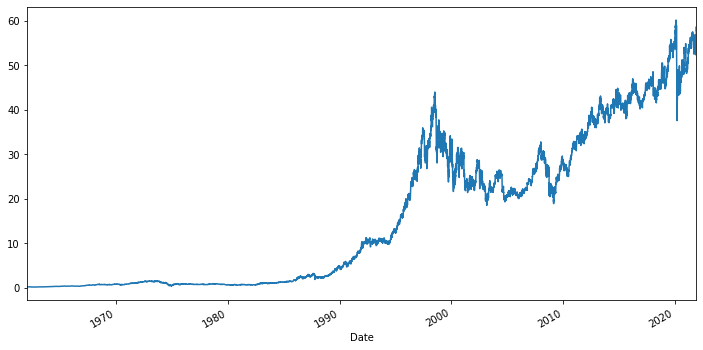

In [6]:
#визуализируем - строим график временного ряда
ax = df['Close'].plot(figsize=(12,6)) 
ax.autoscale(axis='x', tight=True, )

In [7]:
# Смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15096 entries, 1962-01-02 to 2021-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       15096 non-null  float64
 1   High       15096 non-null  float64
 2   Low        15096 non-null  float64
 3   Close      15096 non-null  float64
 4   Adj Close  15096 non-null  float64
 5   Volume     15096 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 825.6 KB


In [8]:
# проверим, отсутствие пропусков по датасету
df_check = df.isna()

for i in df_check.columns:
    print(f'Для признака {i} пропуски: ', df_check[i].unique())

Для признака Open пропуски:  [False]
Для признака High пропуски:  [False]
Для признака Low пропуски:  [False]
Для признака Close пропуски:  [False]
Для признака Adj Close пропуски:  [False]
Для признака Volume пропуски:  [False]


Вывод по 1 этапу : Были загружены необходимые библиотеки, функции, модели, метрики. Был загружен датасет. Датасет пригоден для работы: отсутствуют пропуски, проверен формат данных.

**2 Этап: EDA (exploratory data analysis) или разведочный анализ данных.**

In [9]:
# еще раз смотрим на датасет
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200
1962-01-09,0.250651,0.256510,0.248698,0.255208,0.049614,960000
1962-01-10,0.255208,0.260091,0.252604,0.256510,0.049867,1612800
1962-01-11,0.256510,0.259115,0.255208,0.259115,0.050374,614400
1962-01-12,0.259115,0.259115,0.254557,0.257161,0.049994,883200


In [10]:
# проведем расчет основных статистических метрик датасета
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15096.000000,15096.000000,15096.000000,15096.000000,15096.000000,1.509600e+04
mean,16.056202,16.188428,15.921876,16.060734,11.367487,9.032904e+06
std,16.939301,17.064336,16.811753,16.941712,14.253637,7.935744e+06
min,0.192708,0.193359,0.182292,0.192057,0.037855,7.680000e+04
25%,0.860677,0.869792,0.854167,0.860352,0.242312,2.812800e+06
50%,9.328125,9.398438,9.218750,9.351562,4.642848,7.585200e+06
75%,28.875000,29.167500,28.563125,28.901562,17.251080,1.291275e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,1.241690e+08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9134ea5690>,
      dtype=object)

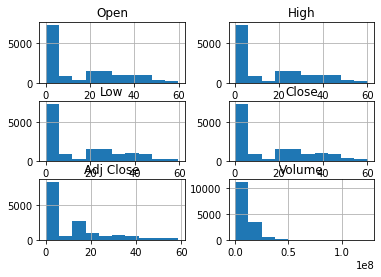

In [11]:
df.hist()

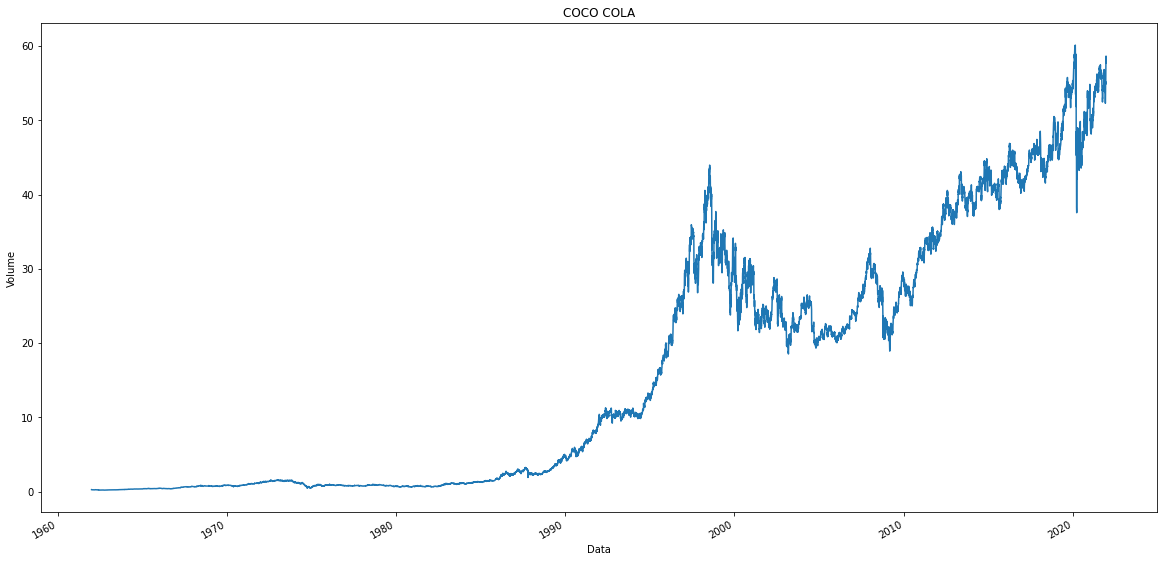

In [12]:
# построим график для метрик
df['Close'].plot(
    figsize=(20, 10), 
    title = 'COCO COLA', 
    xlabel = 'Data', 
    ylabel = 'Volume')

вывод по графику: в целом тренд на рост акций. в 1999 году был первый пик максимальных продаж, второй в 2020. Также следует отметить что характер стартовых фигур пиков очень схож.

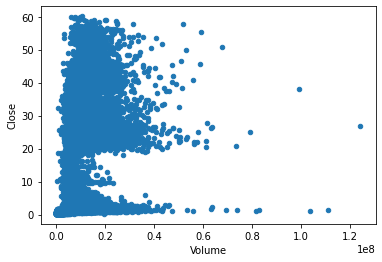

In [13]:
#построим еще график корреляции между ценой закрытия и объемом проданных акций
df.plot.scatter(x='Volume', y='Close')

вывод по графику: наблюдается рост обьема, когда стоимость акций находится в промежутке от 20 до 35, со средних 0,2 до 0,4, т.е. в два раза. Что говорит о том, что рынок/инвесторы считают справедливую стоимость выше 40 


Промежуточный вывод:

Наблюдаем общий восходящий тренд (стоимость акций увеличивается от года к году);
В начале 2020 года наблюдаем возможные предпосылки в повторению ситуаци 1999 года (после пика роста стоимости акций пошел трент на снижение до 2005 года, с последующим осткоком)
Строим гипотезу: стоимость акций в 2020 году будет снижаться до 2021 года

**3 Этап: Построим модели, анализ результатов.**

В связи с большим кол-вом данных и увеличением времени подбора перейдем к недельному интервалу и среднему значению цены на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда

In [14]:
df2 = df.resample('W').mean()

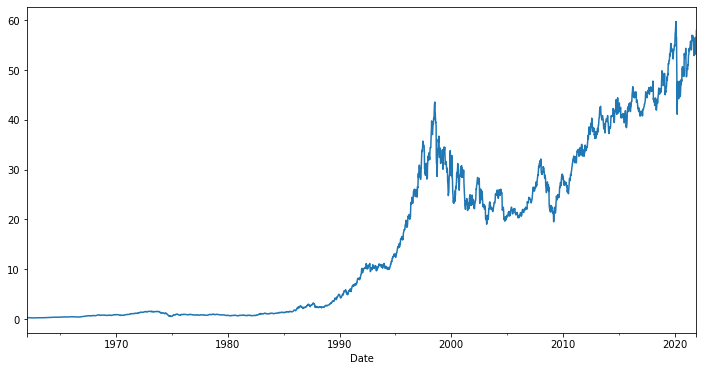

In [15]:
#построим график недельных средних данных стоимости акций
ax = df2['Close'].plot(figsize=(12,6)) 
ax.autoscale(axis='x', tight=True)

In [16]:
df2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-07,0.259766,0.263184,0.256673,0.258138,0.050184,1161600.0
1962-01-14,0.254557,0.257227,0.251367,0.255729,0.049715,1221120.0
1962-01-21,0.248437,0.249740,0.244336,0.245768,0.047779,1482240.0
1962-01-28,0.241667,0.243099,0.237630,0.239713,0.046602,1520640.0
1962-02-04,0.238542,0.242057,0.237435,0.240560,0.046766,1244160.0
...,...,...,...,...,...,...
2021-11-21,56.092000,56.218000,55.630000,55.858000,55.428165,13705640.0
2021-11-28,55.264999,55.680000,54.797501,55.127500,54.703287,14523675.0
2021-12-05,53.311999,53.766000,52.827999,53.188001,53.104000,22010780.0


In [17]:
df_new = df2[['Close']]
df_new

,Close
Date,
1962-01-07,0.258138
1962-01-14,0.255729
1962-01-21,0.245768
1962-01-28,0.239713
1962-02-04,0.240560
...,...
2021-11-21,55.858000
2021-11-28,55.127500
2021-12-05,53.188001


In [18]:
#смотрим размер выборки
df2.index.freq = 'MS' #создаем индекс с частотой начала месяца
print(len(df2))
print(df2.head())

ValueError: ignored

In [19]:
# выделяем выборки, тестовую ограничиваем 1 годом
train = df_new.iloc[:len(df2)-12]
test = df_new.iloc[len(df2)-12:]

In [20]:
# посмотрим на обучающую выборку
train.head()

,Close
Date,
1962-01-07,0.258138
1962-01-14,0.255729
1962-01-21,0.245768
1962-01-28,0.239713
1962-02-04,0.240560


In [21]:
# посмотрим на тестовую выборку
test.head()

,Close
Date,
2021-10-03,52.940000
2021-10-10,53.556001
2021-10-17,54.358001
2021-10-24,54.304000
2021-10-31,55.326000


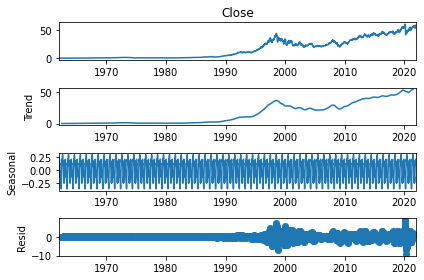

In [22]:
# строим декомпозицию временного ряда (ETS декомпозиция)
r = seasonal_decompose(df2['Close'], model='additive')
r.plot();

Промежуточный вывод: Наблюдаем полобительный тренд и сезонность

**Задачи:**

описать модель
подобрать оптимальные параметры
создать модель
обучить модель
сделать прогноз на период тестовой выборки
сравнить прогноз с тестовой выборкой (построить график)
оценить качество прогноза
сделать прогноз на год
сделать выводы о работе данного метода прогнозирования

**Модель: SARIMAX**

In [32]:
df2.resample('MS').mean().index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', length=720, freq='MS')

In [33]:
# запускаем pmdarima.auto_arima чтобы получить набор параметров
from pmdarima import auto_arima    
auto_arima(df_new['Close'],seasonal=True,m=12)

KeyboardInterrupt: ignored

## **PROPHET**

In [118]:
df_pr=df[['Close']]#подготавливаем датасет для работы

In [123]:
df_pr.head()# для просмотра

,Close
Date,
1962-01-02,0.263021
1962-01-03,0.257161
1962-01-04,0.259115
1962-01-05,0.253255
1962-01-08,0.250651


In [124]:
#загружаем профет
from fbprophet import Prophet

In [125]:
# подготовим данные для модели
train_prophet = train.reset_index() # индекс сбросим, чтобы работать только с колонками
test_prophet = test.reset_index() # индекс сбросим, чтобы работать только с колонками

df_pr=df.reset_index()
df_pr_prophet = df_pr[['Date','Close']]
df_pr_prophet.columns = ['ds', 'y'] # переименовали столбцы

# переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

#выделим тестовую (последний год) и обущающую (до последнего года) выборку
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [126]:
df_pr_prophet.head()

,ds,y
0,1962-01-02,0.263021
1,1962-01-03,0.257161
2,1962-01-04,0.259115
3,1962-01-05,0.253255
4,1962-01-08,0.250651


In [127]:
train_prophet.head() # посмотрим преобразование после переименования колонок

,ds,y
0,1962-01-07,0.258138
1,1962-01-14,0.255729
2,1962-01-21,0.245768
3,1962-01-28,0.239713
4,1962-02-04,0.240560


In [128]:
test_prophet.head() #тестовая

,ds,y
0,2021-10-03,52.940000
1,2021-10-10,53.556001
2,2021-10-17,54.358001
3,2021-10-24,54.304000
4,2021-10-31,55.326000


In [129]:
model = Prophet()
model.fit(train_prophet) # подогнали модель под наши данные

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future = model.make_future_dataframe(periods=12, freq='MS') # говорим профету сделать дата-фрейм на 12 месяцев
future.tail(12) # выводим 12 строк с конца

,ds
3117,2021-10-01
3118,2021-11-01
3119,2021-12-01
3120,2022-01-01
3121,2022-02-01
3122,2022-03-01
3123,2022-04-01
3124,2022-05-01
3125,2022-06-01
3126,2022-07-01


In [131]:
# предсказываем значения по модели, доверительный интервал по умолчанию 95%
forecast = model.predict(future)
forecast.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-07,0.190325,-1.990719,2.739387,0.190325,0.190325,0.125895,0.125895,0.125895,0.125895,0.125895,0.125895,0.0,0.0,0.0,0.316220
1,1962-01-14,0.191844,-1.957755,2.560442,0.191844,0.191844,0.045221,0.045221,0.045221,0.045221,0.045221,0.045221,0.0,0.0,0.0,0.237065
2,1962-01-21,0.193363,-2.075815,2.528320,0.193363,0.193363,-0.062328,-0.062328,-0.062328,-0.062328,-0.062328,-0.062328,0.0,0.0,0.0,0.131034
3,1962-01-28,0.194881,-2.252448,2.320406,0.194881,0.194881,-0.131769,-0.131769,-0.131769,-0.131769,-0.131769,-0.131769,0.0,0.0,0.0,0.063112
4,1962-02-04,0.196400,-2.131214,2.461857,0.196400,0.196400,-0.132814,-0.132814,-0.132814,-0.132814,-0.132814,-0.132814,0.0,0.0,0.0,0.063586


Основные поля в прогнозе следующие:

ds — дата прогноза

yhat — спрогнозированное значение

yhat_lower — нижняя граница доверительного интервала для прогноза

yhat_upper — верхняя граница доверительного интервала для прогноза

In [132]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12) # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
3117,2021-10-01,53.979729,51.669478,56.339307
3118,2021-11-01,54.308059,51.680308,56.601480
3119,2021-12-01,54.829349,52.520842,57.219569
3120,2022-01-01,54.925401,52.657776,57.284377
3121,2022-02-01,54.819020,52.467665,57.244231
3122,2022-03-01,54.923241,52.565916,57.238230
3123,2022-04-01,54.988381,52.735125,57.269976
3124,2022-05-01,55.415180,53.068696,57.838835
3125,2022-06-01,55.903899,53.627848,58.242273
3126,2022-07-01,55.982724,53.686292,58.256525


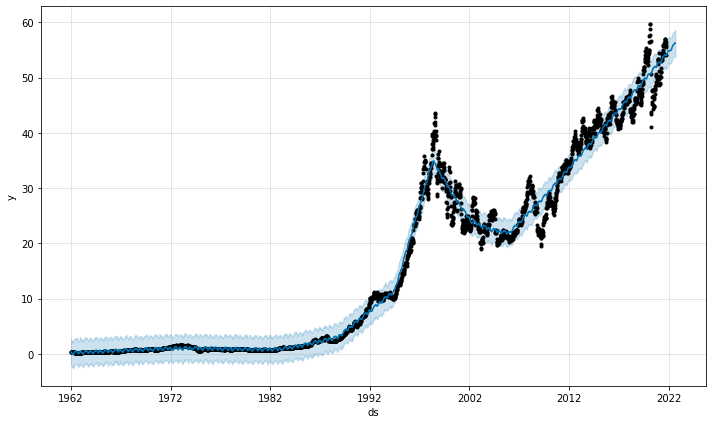

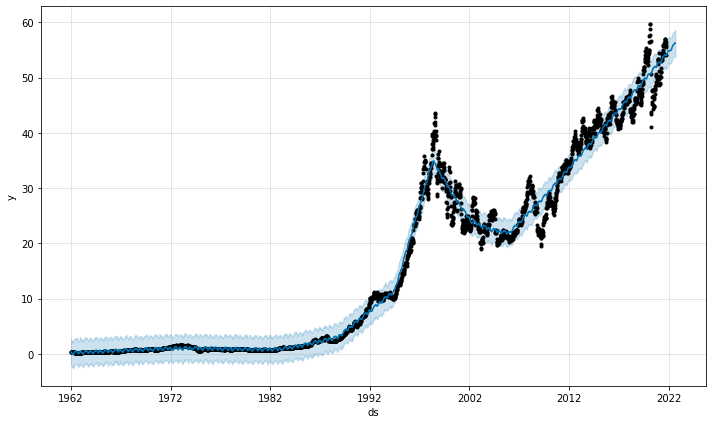

In [133]:
model.plot(forecast) #визуализируем данные, черные точки наши данные

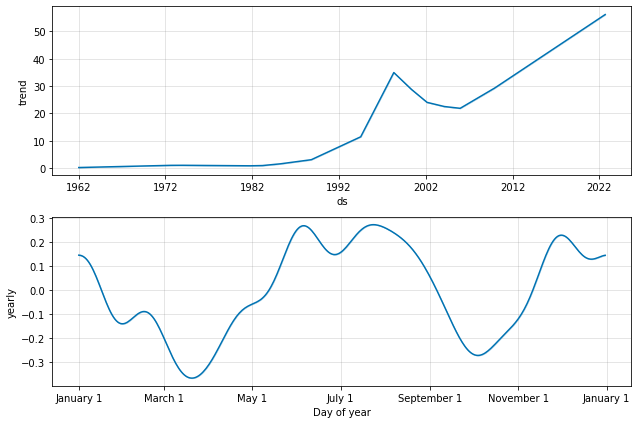

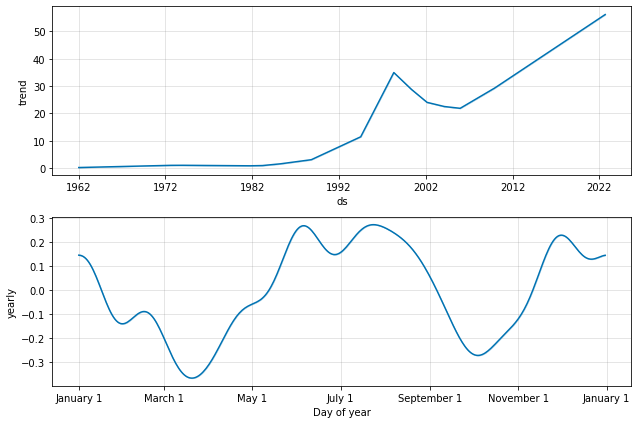

In [134]:
model.plot_components(forecast) #строим график тренда и сезонности

Промежуточные выводы: Видим, что тренд стоимостиакций возрастающий и есть годовая сезонность. ВМожем посмотреть распределенне сезонности по месяцам.

In [135]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE

mae_error = mean_absolute_error(test_prophet['y'], forecast['yhat'].tail(12))
mse_error = mean_squared_error(test_prophet['y'], forecast['yhat'].tail(12))
rmse_error = rmse(test_prophet['y'], forecast['yhat'].tail(12))
mape_error = np.mean(np.abs(forecast['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 1.103619691
Prophet MSE Error: 1.662222502
Prophet RMSE Error: 1.289272082
Prophet MAPE Error: 99.90505014


In [137]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='additive')
fut_model_prophet.fit(df_pr_prophet)

# говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [147]:
# устанавливаем индекс
#fut_fcast_prophet.index = fut_fcast_prophet.ds

In [148]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
1962-01-02,1962-01-02,0.167787,-1.792547,2.640177,0.167787,0.167787,0.113067,0.113067,0.113067,-0.016301,-0.016301,-0.016301,0.129368,0.129368,0.129368,0.0,0.0,0.0,0.280853
1962-01-03,1962-01-03,0.167999,-1.994567,2.475307,0.167999,0.167999,0.106682,0.106682,0.106682,-0.014913,-0.014913,-0.014913,0.121595,0.121595,0.121595,0.0,0.0,0.0,0.274681
1962-01-04,1962-01-04,0.168211,-1.898313,2.398431,0.168211,0.168211,0.092635,0.092635,0.092635,-0.020009,-0.020009,-0.020009,0.112644,0.112644,0.112644,0.0,0.0,0.0,0.260846
1962-01-05,1962-01-05,0.168423,-2.046545,2.439909,0.168423,0.168423,0.082463,0.082463,0.082463,-0.020095,-0.020095,-0.020095,0.102558,0.102558,0.102558,0.0,0.0,0.0,0.250886
1962-01-08,1962-01-08,0.169060,-2.006041,2.563396,0.169060,0.169060,0.042937,0.042937,0.042937,-0.023341,-0.023341,-0.023341,0.066278,0.066278,0.066278,0.0,0.0,0.0,0.211997


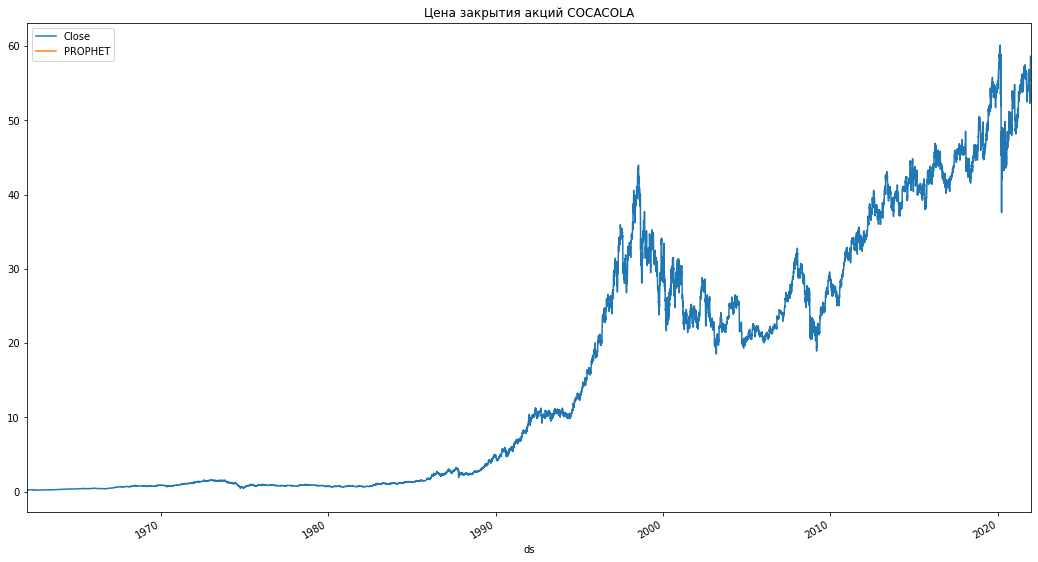

In [158]:
#строим график на будущее

ax = df['Close'].plot(legend=True, figsize=(18,10),title='Цена закрытия акций COCACOLA') 
fut_fcast_prophet['yhat'].tail(12).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Close", "PROPHET"]);

**Вывод:** Процент рассчитанной ошибки MAPE=99,90% - это плохой результат. Метод Prophet неподходит в данном случае для прогнозирования данного временного ряда. Из за ошибоки в ПО оценить до конца метод Sadrimax не удалось.

# **Общий вывод:**
Проведен анализ данных с использованием современных методов обработки информации.
Провести расчёт основных статистических метрик, позволяющие оценить и охарактеризовать объект оценки.
Результаты анализа позволили увидеть возможную закономерность стоимости акций и сделать предположение о стоимости акций на 1 год вперед
Было применено 2 модели прогноза, SARIMAX и PROPHET. Модель PROPHET оказалась не подходящей для данного типа данных, т.к. MAPE (средняя абсолютная процентная ошибка ) МАРЕ =99,90%, возможно SARIMAX показала наилучший результат, но по техническим причинам модель не сделала расчёт.
